In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

# Import and process data

In [2]:
import re
df = pd.read_csv('designs_counts_original.csv')
columns = {'seq_ID': 'seq_id', 
           'aa_sequence': 'seq', 
           'fitness': 'fit', 
           'model': 'model', 
           'mutations': 'mutations',
           'num_muts':'num_mut',
           'modified_codons':'dna_seq',
           'designed_sequence':'final_dna_seq'}
df = df.rename(mapper=columns, axis=1)
def hamming_dist(seq1, seq2):
    return sum([1 for aa1, aa2 in zip(seq1, seq2) if aa1!=aa2])

GB1 = 'MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE' # WT GB1 sequence
df['num_mut'] = [hamming_dist(GB1,s) for s in df.seq]

models = {'lr':'LR', 'fcn':'FCN', 'cnn0':'CNN-1', 'cnn1':'CNN-2', 'cnn2':'CNN-3', 
          'gcn':'GCN', 'med':'EnsM', 'lcb':'EnsC'}
for key, val in models.items():
    df.model = df.model.str.replace(key, val)
df.model = [re.sub(r'[\[\' ]', '', model.split(']')[0]) if isinstance(model, str) and '[' in model else model for model in df.model]
df.to_csv('designs_counts.csv', index=False)
designs_df = df[columns.values()]
designs_df.to_csv('designs.csv', index=False)

In [3]:
df = pd.read_csv('designs_counts.csv')

df['us_0'] = df['GB1_unsorted_lib_S73_L002_210728_count']
df['high_0'] = df['GB1_sorted_high_S77_L002_210728_count'] + df['GB1_sorted_high_S24_L002_210806_count']
df['low_0'] = df['GB1_sorted_low_S75_L002_210728_count'] + df['GB1_sorted_low_S25_L002_210806_count']
df['wteq_0'] = df['GB1_sorted_wtEQ_S76_L002_210728_count']
df['bind_0'] = df['GB1_sorted_myc_S74_L002_210728_count']

df['us_1'] = df['unsorted_lib_rep1_S107_L001_211008_count'] + df['unsorted_lib_rep1_S130_L001_211027_count']
df['bind_1'] = df['sorted_647_rep1_S105_L001_211008_count'] + df['sorted_647_rep1_S128_L001_211027_count']
df['disp_1'] = df['sorted_488_rep1_S103_L001_211008_count']
df['us_2'] = df['unsorted_lib_rep2_S108_L001_211008_count']
df['bind_2'] = df['sorted_647_rep2_S106_L001_211008_count'] + df['sorted_647_rep2_S129_L001_211027_count']
df['disp_2'] = df['sorted_488_rep2_S104_L001_211008_count'] + df['sorted_488_rep2_S127_L001_211027_count']

df = df[[col for col in df.columns if 'count' not in col]]

# filter out sequences with less than read_cut reads in both unsorted libraries 
read_cut = 10
df = df[(df.us_1 > read_cut) & (df.us_2 > read_cut)]

# add pseudocount 
for col in df.columns:
    if col[-2:] in ['_0', '_1', '_2']:
        df[col] = df[col] + 1

# Calculate enrichments 

In [4]:
# normalize columns to get proportions 
df['us_1p'] = df['us_1']/df['us_1'].sum()
df['disp_1p'] = df['disp_1']/df['disp_1'].sum()
df['bind_1p'] = df['bind_1']/df['bind_1'].sum()
df['us_2p'] = df['us_2']/df['us_2'].sum()
df['disp_2p'] = df['disp_2']/df['disp_2'].sum()
df['bind_2p'] = df['bind_2']/df['bind_2'].sum()

In [5]:
# calc enrichments
df['ebind1'] = np.log10(df['bind_1p']) - np.log10(df['disp_1p'])
df['edisp1']= np.log10(0.4*df['disp_1p'] + 0.6*df['bind_1p']) - np.log10(df['us_1p']) # weight disp and bind by counts

df['ebind2'] = np.log10(df['bind_2p']) - np.log10(df['disp_2p'])
df['edisp2']= np.log10(0.4*df['disp_2p'] + 0.6*df['bind_2p']) - np.log10(df['us_2p']) # weight disp and bind by counts

# subtract WT
for var in ['ebind1','edisp1','ebind2','edisp2']:
    df[var] = df[var] - np.median(df[df.num_mut==0][var])

# Reproducibility of metrics 

0.9026987840286375


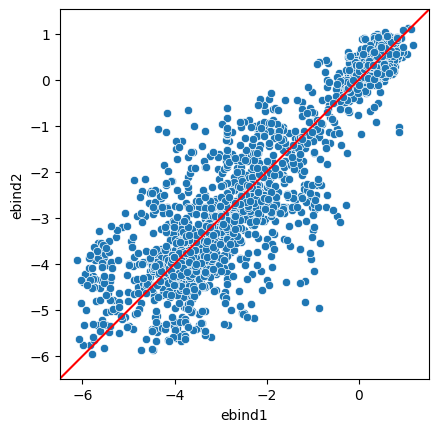

In [6]:
# look at ebind reproducibility between the two replicates
sns.scatterplot(x=df['ebind1'],y=df['ebind2'])
ax = plt.gca()
ax.set_aspect('equal')
CC = np.corrcoef(df['ebind1'],df['ebind2'])[0,1]
lims = ax.get_xlim()
plt.plot(lims,lims,'r')
ax.set_xlim(lims)
ax.set_ylim(lims)
print(CC)
plt.savefig('ebind_rep_correlation.eps')

0.8356567418759115


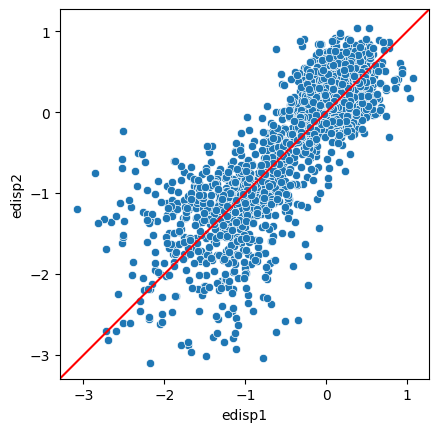

In [7]:
# look at edisp reproducibility between the two replicates
sns.scatterplot(x=df['edisp1'],y=df['edisp2'])
ax = plt.gca()
ax.set_aspect('equal')
CC = np.corrcoef(df['edisp1'],df['edisp2'])[0,1]
lims = ax.get_xlim()
plt.plot(lims,lims,'r')
ax.set_xlim(lims)
ax.set_ylim(lims)
print(CC)
plt.savefig('edisp_rep_correlation.eps')

These look great!

In [8]:
# average the two replicates
df['ebind'] = (df['ebind1'] + df['ebind2'])/2
df['edisp'] = (df['edisp1'] + df['edisp2'])/2

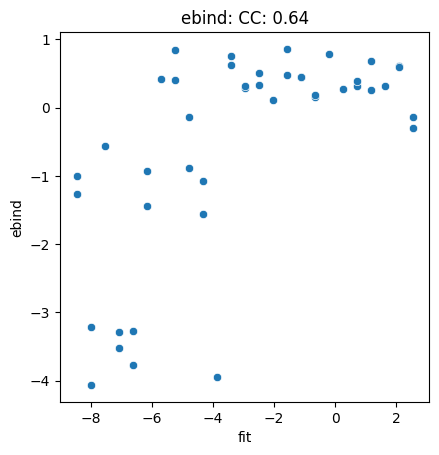

In [9]:
# How does ebind correlate with original DMS fitness?
cal_seqs = pd.read_csv('calibration_seqs.csv')
cal_seqs = df.merge(cal_seqs, how='inner', left_on='seq', right_on='seq',)

sns.scatterplot(x=cal_seqs.fit,y=cal_seqs['ebind'])
CC = np.corrcoef(cal_seqs.fit,cal_seqs['ebind'])[0,1]
plt.gca().set_title('%s: CC: %0.2f' % ('ebind',CC));
plt.gca().set_box_aspect(1)
plt.savefig('ebind_DMS_correlation.eps')

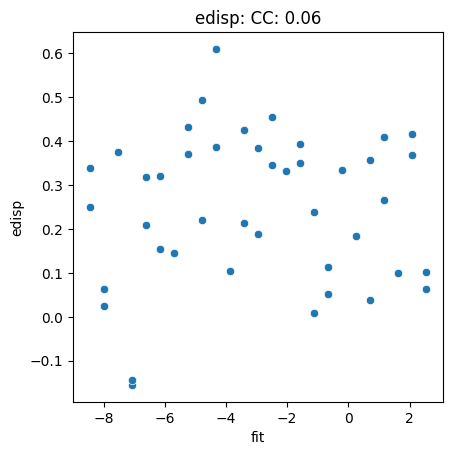

In [10]:
# How does edisp correlate with original DMS fitness?

# select only double mutants
ax = plt.gca()
sns.scatterplot(x=cal_seqs.fit,y=cal_seqs['edisp'])
CC = np.corrcoef(cal_seqs.fit,cal_seqs['edisp'])[0,1]
ax.set_title('%s: CC: %0.2f' % ('edisp',CC));
ax.set_box_aspect(1)
plt.savefig('edisp_DMS_correlation.eps')

ebind: CC: 0.97, ave fold diff: 0.8
For 18 internal standard synonomous sequnences


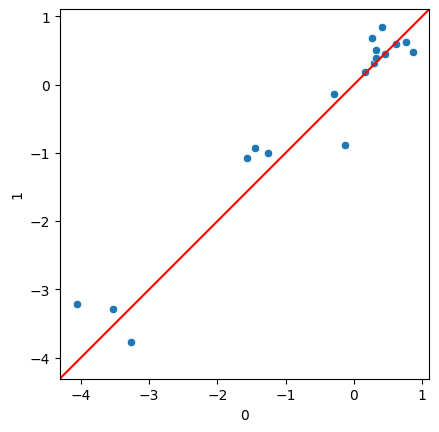

In [11]:
# look at enrichment correlation between 18 synonomous internal standard sequences 

# select only double mutants 
sel = df[df.num_mut==2]
seqs = sorted(set(sel.seq))
var = 'ebind'
ax = plt.gca()

data = []
for seq in seqs:
    if len(sel[sel.seq==seq])==2:
        data.append(sel[sel.seq==seq][var].tolist())

df2 = pd.DataFrame(data)
CC = np.corrcoef(df2.T)[0,1]
MAD = np.mean(abs(df2[0] - df2[1]))
print('%s: CC: %0.2f, ave fold diff: %0.1f' % (var,CC,MAD*2.71))

sns.scatterplot(x=df2[0],y=df2[1])
ax = plt.gca()
ax.set_aspect('equal')
lims = ax.get_xlim()
plt.plot(lims,lims,'r')
ax.set_xlim(lims)
ax.set_ylim(lims)
print('For %i internal standard synonomous sequnences' % len(data))
plt.savefig('ebind_internal_correlation.eps')

edisp: CC: 0.60, ave fold diff: 0.4
For 18 internal standard synonomous sequnences


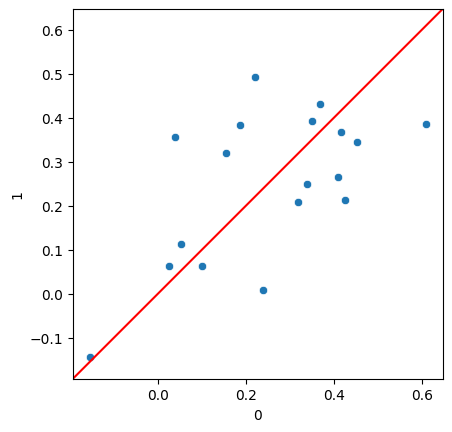

In [12]:
# look at enrichment correlation between 18 synonomous internal standard sequences 

# select only double mutants 
sel = df[df.num_mut==2]
seqs = sorted(set(sel.seq))
var = 'edisp'
    
data = []
for seq in seqs:
    if len(sel[sel.seq==seq])==2:
        data.append(sel[sel.seq==seq][var].tolist())

df2 = pd.DataFrame(data)
CC = np.corrcoef(df2.T)[0,1]
MAD = np.mean(abs(df2[0] - df2[1]))
print('%s: CC: %0.2f, ave fold diff: %0.1f' % (var,CC,MAD*2.71))

sns.scatterplot(x=df2[0],y=df2[1])
ax = plt.gca()
ax.set_aspect('equal')
lims = ax.get_xlim()
plt.plot(lims,lims,'r')
ax.set_xlim(lims)
ax.set_ylim(lims)
print('For %i internal standard synonomous sequnences' % len(data))
plt.gca().set_box_aspect(1)
plt.savefig('edisp_internal_correlation.eps')

# ebind metric

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Cutoff between positive and negative: -0.50


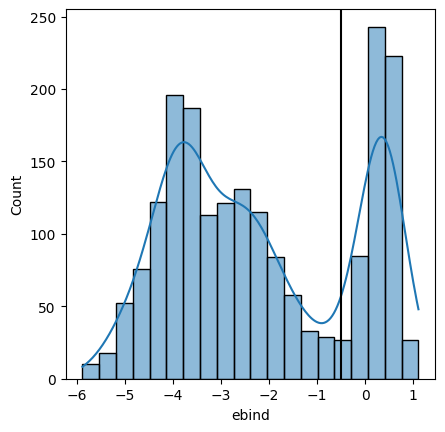

In [13]:
# two Gaussian's do not give good estimate of bcutoff, so set it manually
bcutoff = -0.5

nbins = 20
sns.histplot(df['ebind'], bins = nbins, kde=True);

ylim = plt.gca().get_ylim()
print('Cutoff between positive and negative: %0.2f' % bcutoff)
plt.plot([bcutoff,bcutoff], ylim, color='k');
plt.gca().set_box_aspect(1)
plt.gca().set_ylim(ylim)
plt.savefig('ebind_hist.eps')

# edisp metric

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Parameters: 0.23, 0.22, 355.80, -1.11, 0.53, 115.22
Cutoff between positive and negative: -0.26


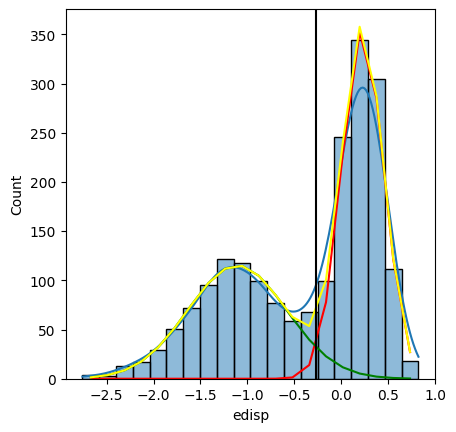

In [14]:
# fit two Gaussians to histogram 
nbins = 20 # final cutoff seems to be largly independent of nbins
y,edges = np.histogram(df.edisp,nbins)
x = (edges[1:]+edges[:-1])/2 # get bin center

def gauss(x,mu,sigma,A):
    return A*np.exp(-0.5*((x-mu)/sigma)**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

params,cov=curve_fit(bimodal,x,y,(0.5,1,250,-1,1,250), 
                     bounds=[(0, 0, 0, -np.inf, 0, 0), (2, np.inf, 500, 0, np.inf, 500)])

sns.histplot(df.edisp, bins = nbins, kde=True);
plt.plot(x,gauss(x,*params[:3]),color='red')
plt.plot(x,gauss(x,*params[-3:]),color='green')
plt.plot(x,bimodal(x,*params),color='yellow')

print('Parameters: '+', '.join(['%0.2f'%p for p in params]))

# determine when the positive distrbution becomes more likely 
x = np.linspace(-3,0,10000)
ylim = plt.gca().get_ylim()
dcutoff = x[np.argmax(gauss(x,*params[:3]) > gauss(x,*params[-3:]))] # Gauss1 > Gauss2
print('Cutoff between positive and negative: %0.2f' % dcutoff)
plt.plot([dcutoff,dcutoff],ylim, color='k');
plt.gca().set_ylim(ylim)
plt.gca().set_box_aspect(1)
plt.savefig('edisp_hist.eps')

This is actually what we expect. We want all these sequences to be in the "folded" category.  

Fold and bind: 0.305
Fold and don't bind: 0.274
Don't fold and bind: 0.001
Don't fold and don't bind:0.419


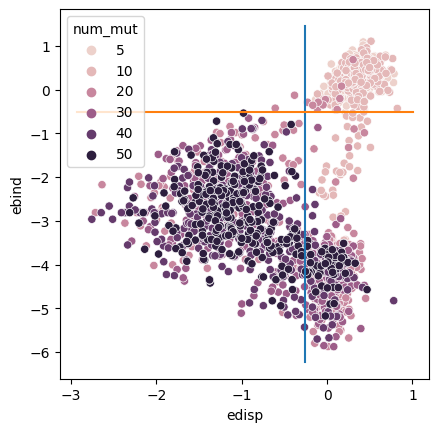

In [15]:
# look into performance of individual designs 
sel = df[df.num_mut>2]
sns.scatterplot(x=sel.edisp,y=sel.ebind,hue=sel.num_mut)
plt.plot([dcutoff,dcutoff], plt.gca().get_ylim())
plt.plot(plt.gca().get_xlim(),[bcutoff,bcutoff]);
plt.gca().set_box_aspect(1)
plt.savefig('bind_display_quadrants.svg', format='svg')

# proportion in the four quadrants 
fb = np.mean((df.ebind>bcutoff) & (df.edisp>dcutoff))
fn = np.mean((df.ebind<bcutoff) & (df.edisp>dcutoff))
ub = np.mean((df.ebind>bcutoff) & (df.edisp<dcutoff))
un = np.mean((df.ebind<bcutoff) & (df.edisp<dcutoff))
print("Fold and bind: %0.3f\nFold and don't bind: %0.3f\nDon't fold and bind: %0.3f\nDon't fold and don't bind:%0.3f"%(fb,fn,ub,un))

# Look at differences in design strategies

In [16]:
# add in model columns 
models = ['LR','FCN','CNN-1','CNN-2','CNN-3','GCN','EnsM','EnsC']
for model in models:
    mod1 = [m==model for m in df.model]
    mod2 = [(len(str(m))>4) and (model in m) for m in df.model] # To catch few cases where multiple models designed same sequence "['fcn', 'lr', 'lcb'], indices of replicate sequences: [31, 93, 192]"
    df[model] = [any((mod1[i],mod2[i])) for i in range(len(mod1))]


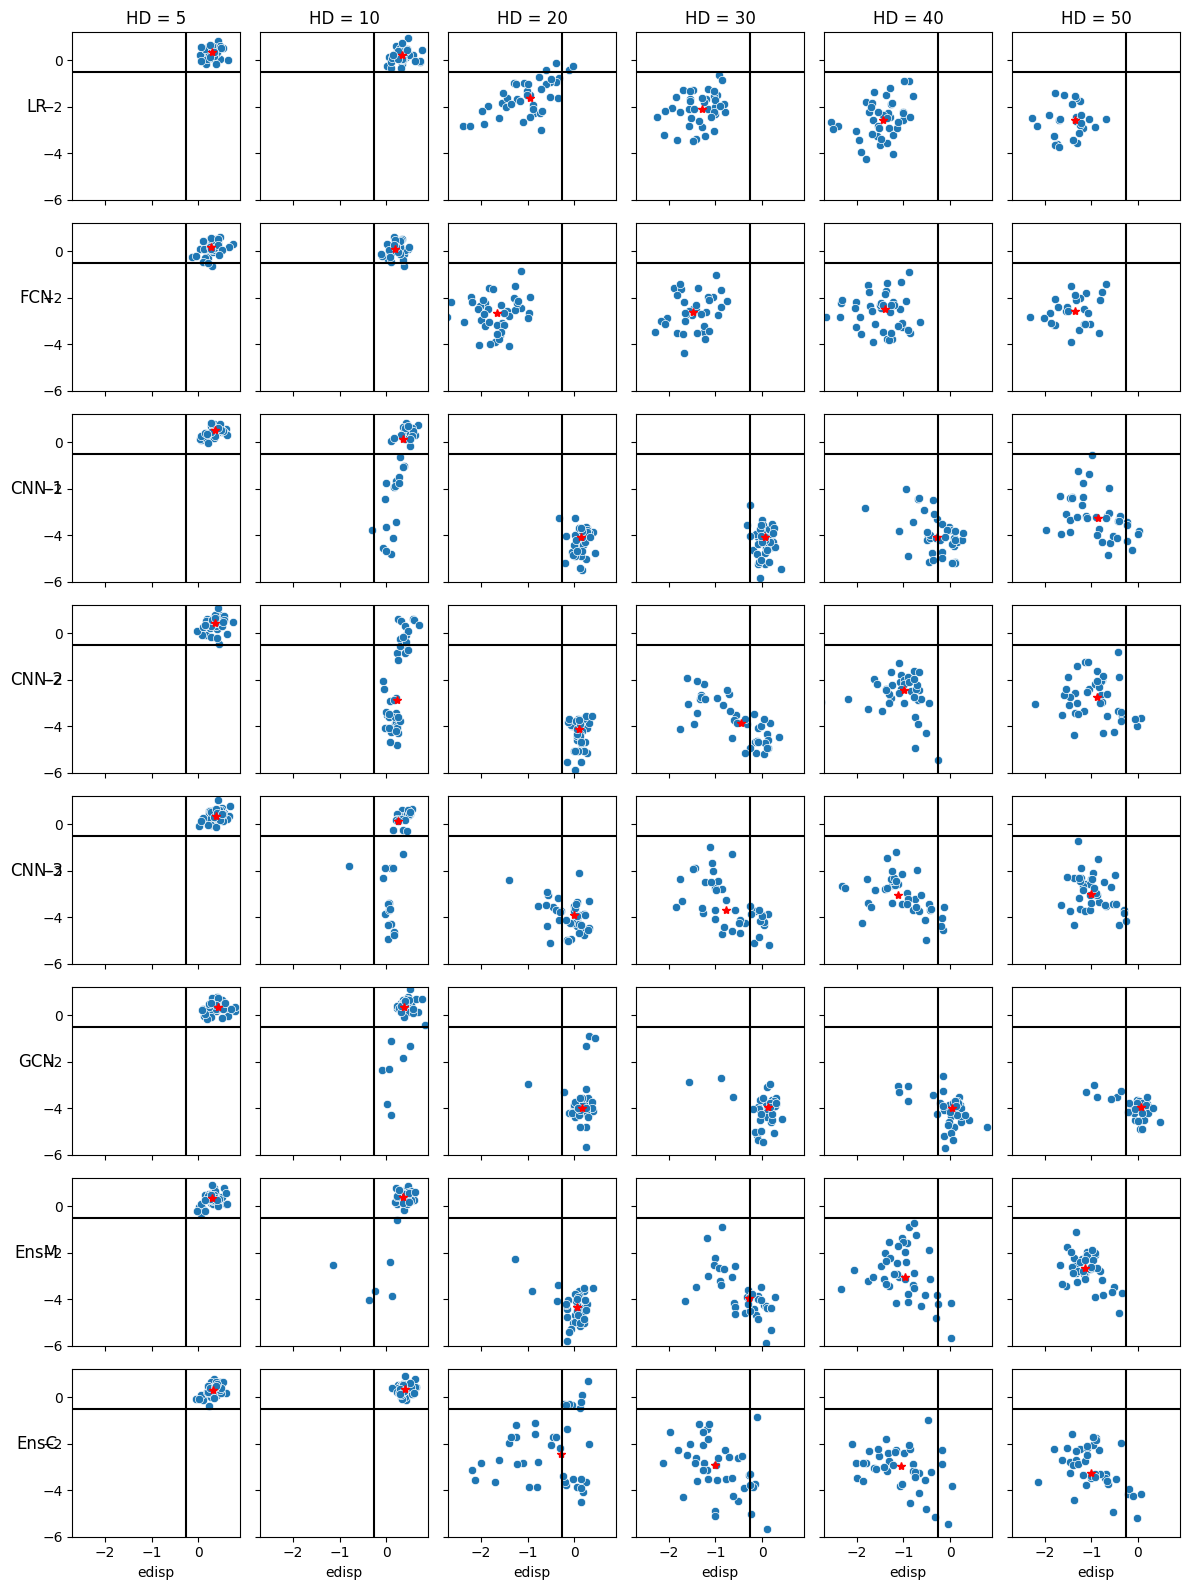

In [17]:
distances = [5, 10, 20, 30, 40, 50]

fig, axes = plt.subplots(8, 6, figsize=(12,16),sharex=True, sharey=True)

for i,num_mut in enumerate(distances): 
    for j,model in enumerate(models):
        sel = df[(df.num_mut==num_mut) & df[model]]
        sns.scatterplot(ax=axes[j,i],x=sel.edisp,y=sel.ebind)
        axes[j,i].plot(np.median(sel.edisp),np.median(sel.ebind),'r*') # put a red star at median
        axes[j,i].plot([dcutoff,dcutoff],[-10,5],'k')
        axes[j,i].plot([-5,5],[bcutoff,bcutoff],'k')
        axes[j,i].set_xlim(-2.7,0.9)
        axes[j,i].set_ylim(-6,1.2)
        
# add column and row titles 
for ax, col in zip(axes[0], ['HD = %i'%d for d in distances]):
    ax.set_title(col)

for ax, row in zip(axes[:,0], models):
    ax.set_ylabel(row, rotation=0, size='large')

fig.tight_layout()
plt.savefig('design_matrix.eps')

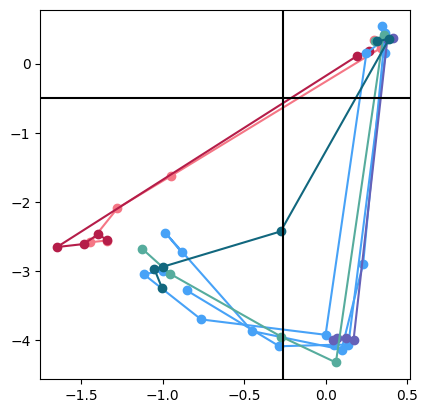

In [18]:
colors = {'LR':'#F57685', 'FCN':'#B51D49', 'CNN-1':'#47A2F7','CNN-2':'#47A2F7','CNN-3':'#47A2F7', 'GCN':'#6561B8', 'EnsC':'#11677E', 'EnsM':'#56AC9D'}

distances = [5, 10, 20, 30, 40, 50]

for model in models:
    mb = []
    md = []
    for num_mut in distances: 
        sel = df[(df.num_mut==num_mut) & df[model]]
        mb.append(np.median(sel.ebind))
        md.append(np.median(sel.edisp))
    plt.plot(md,mb,'o-',color=colors[model])

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
plt.plot([dcutoff,dcutoff],ylim, color='k')
plt.plot(xlim,[bcutoff,bcutoff], color='k')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.gca().set_box_aspect(1)
plt.savefig('design_medians.eps')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 26.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 17.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 17.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 20.5% of the points cannot be placed; you may want to decrease the size of the markers or use s

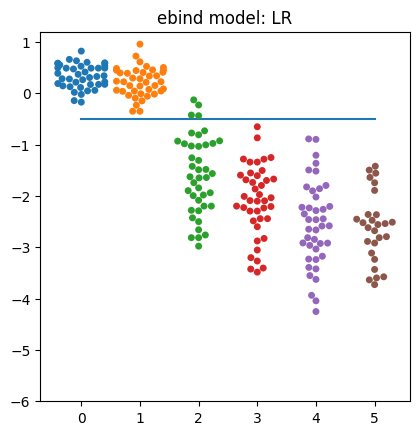

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 17.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 20.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


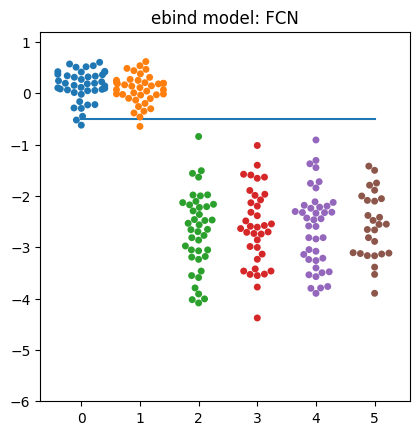

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 29.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


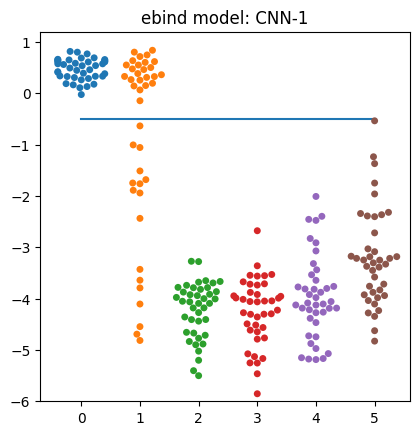

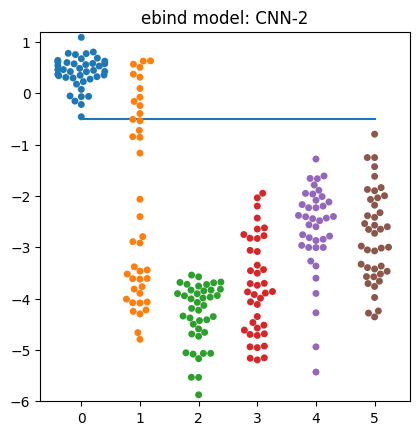

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 22.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


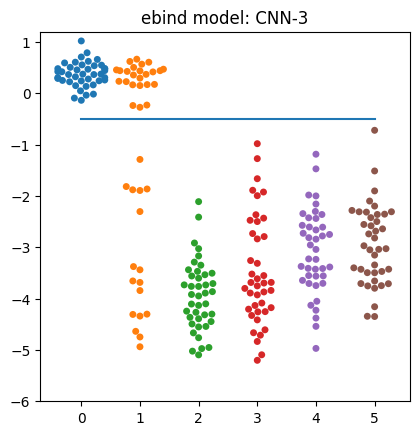

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 22.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


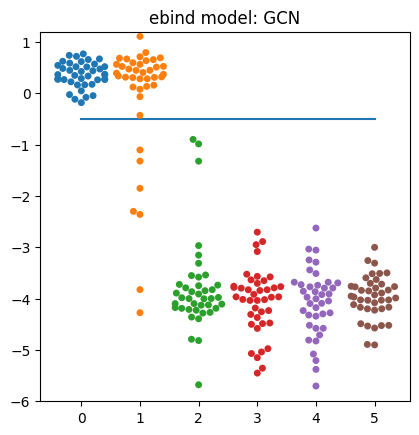

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 14.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


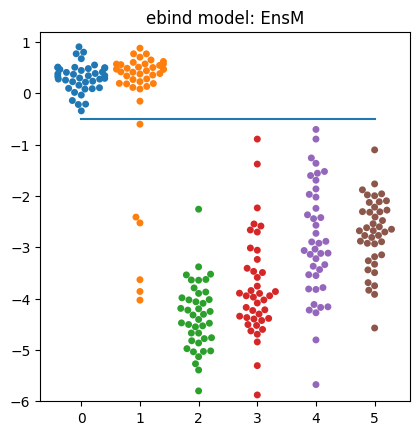

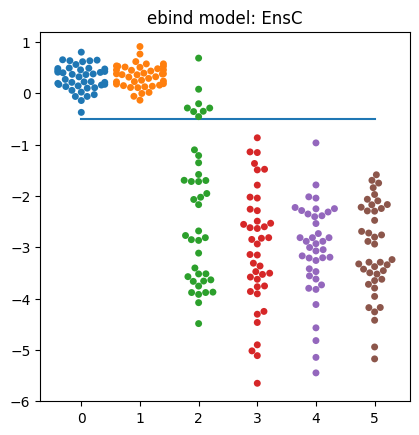

In [19]:
var = 'ebind'
for m in models:
    violin_plot_bind = [list(df[df[m] & (df.num_mut==d)][var]) for d in distances]
    plt.figure()
    sns.swarmplot(violin_plot_bind)
    plt.plot([0,5],[bcutoff,bcutoff])
    plt.title(f'{var} model: {m}')
    plt.ylim([-6, 1.2])
    plt.xlim(-0.7,5.6)
    plt.gca().set_box_aspect(1)
    plt.savefig(f'{var}_{m}.eps')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 22.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 17.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 12.8% of the points cannot be placed; you may want to decrease the size of the markers or use s

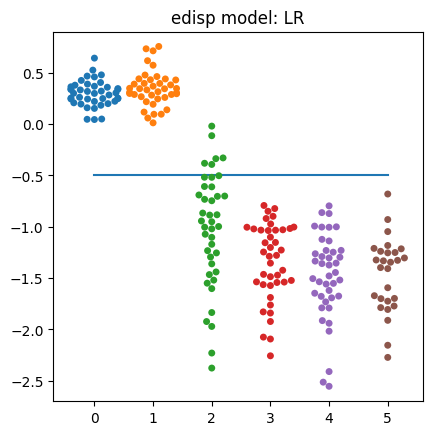

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 12.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


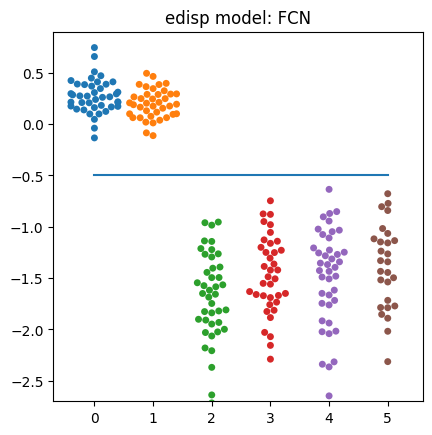

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 19.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


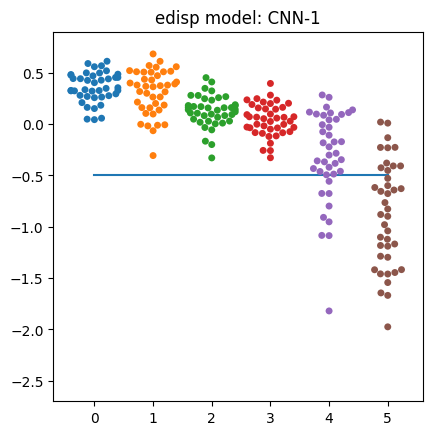

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 14.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 26.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


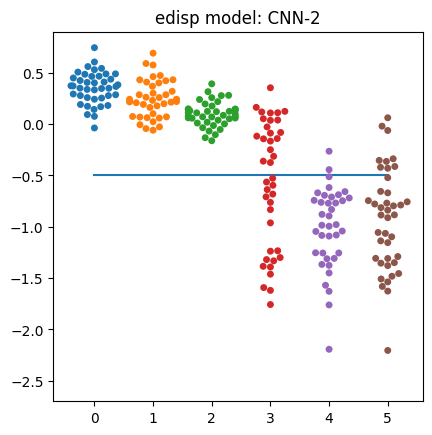

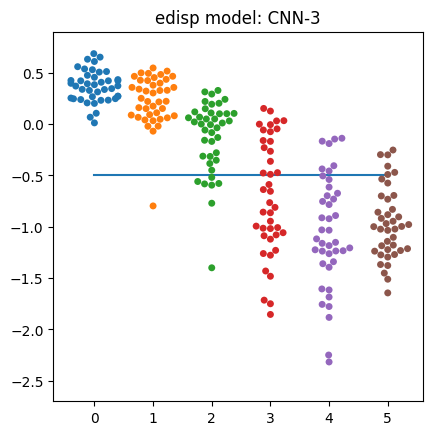

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 7.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 9.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use str

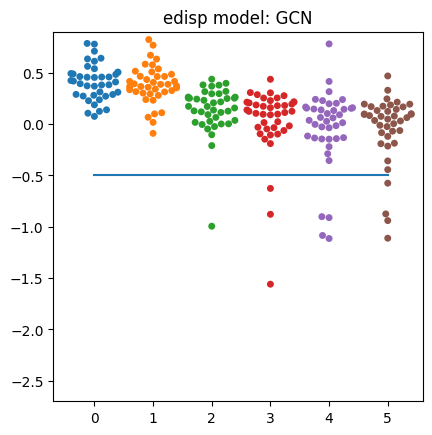

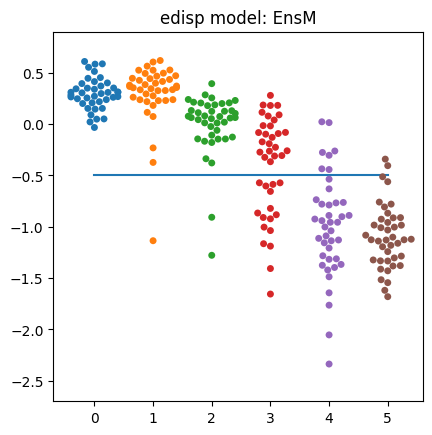

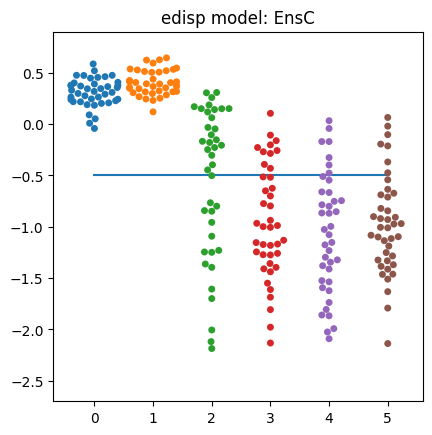

In [20]:
var = 'edisp'
for m in models:
    violin_plot_bind = [list(df[df[m] & (df.num_mut==d)][var]) for d in distances]
    plt.figure()
    sns.swarmplot(violin_plot_bind)
    plt.plot([0,5],[bcutoff,bcutoff])
    plt.title(f'{var} model: {m}')
    plt.ylim([-2.7,0.9])
    plt.xlim(-0.7,5.6)
    plt.gca().set_box_aspect(1)
    plt.savefig(f'{var}_{m}.eps')